# Variance Reduction - Weight Windows

## Creating and utilizing a wight window to accelerate the deep shielding simulations

This example simulates a shield room / bunker with corridor entrance a neutron source in the center of the room with This example implements a single step of the Magic method of weight window generation. 

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield.

Weight Windows are found using the MAGIC method and used to accelerate the simulation.

The variance reduction method used for this simulation is well documented in the OpenMC documentation
https://docs.openmc.org/en/stable/methods/neutron_physics.html

The MAGIC method is well described in the original publication
https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf

This example has been copied with permission from the neutronics-workshop
https://github.com/fusion-energy/neutronics-workshop


First we import ```openmc``` including ```openmc.lib``` and other packages needed for the example

In [1]:
import time  # used to time the simulation

import openmc
import openmc.lib  # this example makes use of openmc lib to run the simulations

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm  # used for plotting log scale graphs

In [2]:
!rm model.xml statepoint.*.h5

rm: cannot remove 'model.xml': No such file or directory
rm: cannot remove 'statepoint.*.h5': No such file or directory


We create a couple of materials for the simulation

In [3]:
mat_air = openmc.Material(name="Air")
mat_air.add_element("N", 0.784431)
mat_air.add_element("O", 0.210748)
mat_air.add_element("Ar", 0.0046)
mat_air.set_density("g/cc", 0.001205)

mat_concrete = openmc.Material(name='Concrete')
mat_concrete.add_element("H",0.168759)
mat_concrete.add_element("C",0.001416)
mat_concrete.add_element("O",0.562524)
mat_concrete.add_element("Na",0.011838)
mat_concrete.add_element("Mg",0.0014)
mat_concrete.add_element("Al",0.021354)
mat_concrete.add_element("Si",0.204115)
mat_concrete.add_element("K",0.005656)
mat_concrete.add_element("Ca",0.018674)
mat_concrete.add_element("Fe",0.00426)
mat_concrete.set_density("g/cm3", 2.4)

materials = openmc.Materials([mat_air, mat_concrete])

material_colors = {mat_air: 'pink', mat_concrete: 'grey'}

Now we define and plot the geometry. This geometry is define by parameters for every width and height. The parameters input into the geometry in a stacked manner so they can easily be adjusted to change the geometry without creating overlapping cells.

In [4]:
width_a = 100
width_b = 200
width_c = 500
width_d = 250
width_e = 200
width_f = 200
width_g = 100

depth_a = 100
depth_b = 200
depth_c = 700
depth_d = 600
depth_e = 200
depth_f = 100

height_j = 100
height_k = 500
height_l = 100

xplane_0 = openmc.XPlane(x0=0, boundary_type="vacuum")
xplane_1 = openmc.XPlane(x0=xplane_0.x0 + width_a)
xplane_2 = openmc.XPlane(x0=xplane_1.x0 + width_b)
xplane_3 = openmc.XPlane(x0=xplane_2.x0 + width_c)
xplane_4 = openmc.XPlane(x0=xplane_3.x0 + width_d)
xplane_5 = openmc.XPlane(x0=xplane_4.x0 + width_e)
xplane_6 = openmc.XPlane(x0=xplane_5.x0 + width_f)
xplane_7 = openmc.XPlane(x0=xplane_6.x0 + width_g, boundary_type="vacuum")

yplane_0 = openmc.YPlane(y0=0, boundary_type="vacuum")
yplane_1 = openmc.YPlane(y0=yplane_0.y0 + depth_a)
yplane_2 = openmc.YPlane(y0=yplane_1.y0 + depth_b)
yplane_3 = openmc.YPlane(y0=yplane_2.y0 + depth_c)
yplane_4 = openmc.YPlane(y0=yplane_3.y0 + depth_d)
yplane_5 = openmc.YPlane(y0=yplane_4.y0 + depth_e)
yplane_6 = openmc.YPlane(y0=yplane_5.y0 + depth_f, boundary_type="vacuum")

zplane_1 = openmc.ZPlane(z0=0, boundary_type="vacuum")
zplane_2 = openmc.ZPlane(z0=zplane_1.z0 + height_j)
zplane_3 = openmc.ZPlane(z0=zplane_2.z0 + height_k)
zplane_4 = openmc.ZPlane(z0=zplane_3.z0 + height_l, boundary_type="vacuum")

outside_left_region = +xplane_0 & -xplane_1 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4
wall_left_region = +xplane_1 & -xplane_2 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
wall_right_region = +xplane_5 & -xplane_6 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3
wall_top_region = +xplane_1 & -xplane_4 & +yplane_4 & -yplane_5 & +zplane_2 & -zplane_3
outside_top_region = +xplane_0 & -xplane_7 & +yplane_5 & -yplane_6 & +zplane_1 & -zplane_4
wall_bottom_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_2 & +zplane_2 & -zplane_3
outside_bottom_region = +xplane_0 & -xplane_7 & +yplane_0 & -yplane_1 & +zplane_1 & -zplane_4
wall_middle_region = +xplane_3 & -xplane_4 & +yplane_3 & -yplane_4 & +zplane_2 & -zplane_3
outside_right_region = +xplane_6 & -xplane_7 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4

room_region = +xplane_2 & -xplane_3 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
gap_region = +xplane_3 & -xplane_4 & +yplane_2 & -yplane_3 & +zplane_2 & -zplane_3
corridor_region = +xplane_4 & -xplane_5 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3

roof_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_2
floor_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_3 & -zplane_4

outside_left_cell = openmc.Cell(region=outside_left_region, fill=mat_air)
outside_right_cell = openmc.Cell(region=outside_right_region, fill=mat_air)
outside_top_cell = openmc.Cell(region=outside_top_region, fill=mat_air)
outside_bottom_cell = openmc.Cell(region=outside_bottom_region, fill=mat_air)
wall_left_cell = openmc.Cell(region=wall_left_region, fill=mat_concrete)
wall_right_cell = openmc.Cell(region=wall_right_region, fill=mat_concrete)
wall_top_cell = openmc.Cell(region=wall_top_region, fill=mat_concrete)
wall_bottom_cell = openmc.Cell(region=wall_bottom_region, fill=mat_concrete)
wall_middle_cell = openmc.Cell(region=wall_middle_region, fill=mat_concrete)
room_cell = openmc.Cell(region=room_region, fill=mat_air)
gap_cell = openmc.Cell(region=gap_region, fill=mat_air)
corridor_cell = openmc.Cell(region=corridor_region, fill=mat_air)

roof_cell = openmc.Cell(region=roof_region, fill=mat_concrete)
floor_cell = openmc.Cell(region=floor_region, fill=mat_concrete)

geometry = openmc.Geometry(
    [
        outside_bottom_cell,
        outside_top_cell,
        outside_left_cell,
        outside_right_cell,
        wall_left_cell,
        wall_right_cell,
        wall_top_cell,
        wall_bottom_cell,
        wall_middle_cell,
        room_cell,
        gap_cell,
        corridor_cell,
        roof_cell,
        floor_cell,
    ]
)


Now we plot the geometry and color by materials.

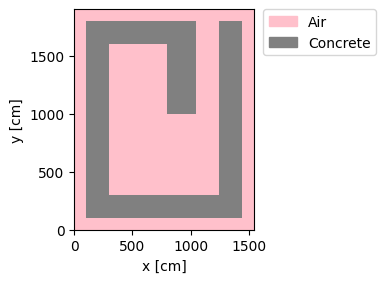

In [5]:
geometry.root_universe.plot(basis='xy', color_by='material', colors=material_colors, legend=True) 
plt.savefig('geometry_top_down_view.png', bbox_inches="tight")
plt.show()

Next we create a point source, this also uses the same geometry parameters to place in the center of the room regardless of the values of the parameters.

In [6]:
# location of the point source
space = openmc.stats.Point((550, 1200, height_j + height_k *0.5))

angle = openmc.stats.Isotropic()

# all (100%) of source particles are 2.5 MeV energy
energy = openmc.stats.Discrete([2.5e6], [1.0])

source = openmc.IndependentSource(particle='neutron', space=space, angle=angle, energy=energy)

Next we create a mesh that encompasses the entire geometry and scores neutron flux

In [8]:
mesh

RegularMesh
	ID             =	2
	Name           =	
	Dimensions     =	3
	Voxels         =	(500, 500, 1)
	Lower left     =	[0. 0. 0.]
	Upper Right    =	[1550. 1900.  700.]
	Width          =	None

In [7]:
mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (500, 500, 1)

mesh_filter = openmc.MeshFilter(mesh)
particle_filter = openmc.ParticleFilter('neutron')

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter, particle_filter]
flux_tally.scores = ["flux"]

tallies = openmc.Tallies([flux_tally])

Creates the simulation settings

In [9]:
settings = openmc.Settings()
settings.run_mode = "fixed source"
settings.source = source
settings.particles = 10000
settings.batches = 5
# no need to write the tallies.out file which saves space and time when large meshes are used
settings.output = {'tallies': False}
settings.weight_window_checkpoints = {'collision': True, 'surface': True}
settings.weight_windows_on = True

Creates and export the model

In [10]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml()

Now we make use of openmc.lib to control the simulation. Documentation on openmc.lib is here
https://docs.openmc.org/en/stable/pythonapi/capi.html

We also time the simulation so that we can perform the same simulation again with weight windows and try to fine tune the particle so that both simulations take the same time and we are making a fair comparision.

In [11]:
# this helps time the simulation
t0 = time.time()

# first we initialize openmc lib, this reads in the model.xml and material cross sections 
openmc.lib.init()

# This runs openmc with the settings provided earlier
openmc.lib.run()

# End the connection to openmc lib and write out the statepoint file
openmc.lib.finalize()

t1 = time.time()

total = t1-t0

print(f'total time without weight windows {total}s')

total time without weight windows 6.79154896736145s


Now we want to plot the results of the simulation. We want to do this twice to compare the results so I've written this up as a function that we can call.

In [12]:
def plot_mesh_tally(model, statepoint_filename, geometry=True):

    with openmc.StatePoint(statepoint_filename) as sp:
        flux_tally = sp.get_tally(name="flux tally")

    mesh_extent = mesh.bounding_box.extent['xy']
    
    # get a slice of mean values on the xy basis mid z axis
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True).squeeze()
    mean = flux_mean.T / mesh.volumes[0]
    ax = plt.subplot(1, 2, 1)
    # create a plot of the mean flux values
    model.geometry.plot(axes=ax, color_by='material', colors=material_colors, alpha=0.5)
    plt.imshow(
        mean,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )

    plt.colorbar(label='flux/src-particle')
    plt.title("Flux Mean")
    
    ax = plt.subplot(1, 2, 2)
    # get a slice of std dev values on the xy basis mid z axis
    flux_std_dev = flux_tally.get_reshaped_data(value='std_dev', expand_dims=True).squeeze()
    # create a plot of the flux relative error
    model.geometry.plot(axes=ax, color_by='material', alpha=0.5, colors=material_colors)  
    plt.imshow(
        flux_std_dev.T/flux_mean.T,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )
    plt.title("Flux Rel. Err.")
    plt.colorbar(label='Rel. Err.')
    plt.subplots_adjust(hspace=0.2)
    plt.show()

This next section calls the plotting function and saves an image of the mesh tally as no_ww.png

<ipython-input-12-63ec263adb15>:30: RuntimeWarning: invalid value encountered in divide
  flux_std_dev.T/flux_mean.T,


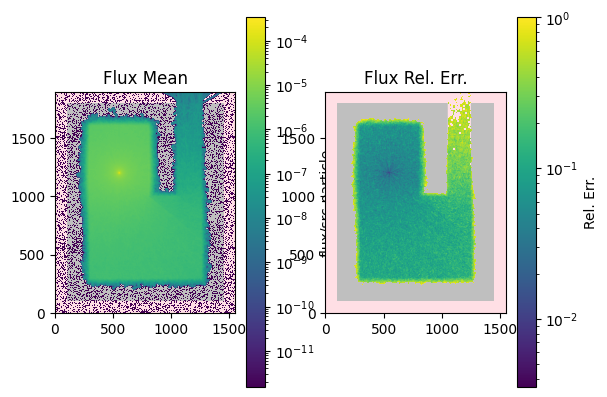

In [13]:
plot_mesh_tally(model, f'statepoint.{settings.batches}.h5')
plt.show()

Now we want to run the simulation twice. Once to generate weight windows and once to make use of the weight windows. We are going to adjust the number of particles to try and spend the same total amount of computer time as the last simulation and make this a fair test. This might require some adaption of the particles as the simulation is set up for my laptop.

In [14]:
# this helps time the simulation
t0 = time.time()

with openmc.lib.run_in_memory():
    # Now we find the mesh tally that will be used for creating the weight windows 
    # At this point the tally is empty.
    tally = openmc.lib.tallies[flux_tally.id]
 
    # We create a weight window object from the empty tally. 
    wws = openmc.lib.WeightWindows.from_tally(tally)

    # Now we enable weight window usage, previously this was set to False by default
    openmc.lib.settings.weight_windows_on = True
    
    # We are running a fraction of particles of the original simulation as we want
    # to take less simulation time for the first run and leave some simulation time
    # for the run with weight windows.
    openmc.lib.settings.particles = 600

    # This runs openmc with the settings provided earlier
    openmc.lib.simulation_init()
    for _ in openmc.lib.iter_batches():
        # The tally now contains meaningful information.
        # So we can update the weight windows from the tally.
        # This uses the MAGIC method to update the weight windows
        # after each batch of particles
        wws.update_magic(tally, threshold=0.7)

        # increase the 
        openmc.lib.settings.particles += 1000
        
        
    # write a 'weight_windows.h5' file
    openmc.lib.export_weight_windows()
    openmc.lib.reset()

t1 = time.time()

total = t1-t0

print(f'total time with weight windows {total}s')

total time with weight windows 37.127787351608276s


In [16]:
!ls -ltr

total 89264
drwxr-x--x 2 shriwise pvt-shriwise     8192 Feb 19 17:01  images
-rw-r--r-- 1 shriwise pvt-shriwise     3601 Feb 19 17:06 'Introduction to OpenMC.ipynb'
-rw-r--r-- 1 shriwise pvt-shriwise    97015 Mar  2 23:13 'Geometry Basics.ipynb'
-rw-r--r-- 1 shriwise pvt-shriwise   258967 Mar  5 17:14 'Advanced Geometry.ipynb'
-rw-r----- 1 shriwise pvt-shriwise   577052 Mar  5 17:14 'Advanced Geometry.slides.html'
-rw-r----- 1 shriwise pvt-shriwise   169020 Mar 13 11:02  Materials.ipynb
-rw-r----- 1 shriwise pvt-shriwise   459291 Mar 13 11:02  Materials.slides.html
-rw-r----- 1 shriwise pvt-shriwise   328606 Mar 17 22:49  Sources.slides.html
-rw-r----- 1 shriwise pvt-shriwise    41471 Mar 17 22:50  Sources.ipynb
-rw-r----- 1 shriwise pvt-shriwise     2262 Mar 30 23:35  plot_5.png
-rw-r----- 1 shriwise pvt-shriwise   431712 Mar 31 00:23  Tallies.slides.html
-rw-r----- 1 shriwise pvt-shriwise   146668 Mar 31 23:44  Tallies.ipynb
drwxr-x--x 3 shriwise pvt-shriwise     8192 Apr  1 13:45  i

<ipython-input-12-63ec263adb15>:30: RuntimeWarning: invalid value encountered in divide
  flux_std_dev.T/flux_mean.T,


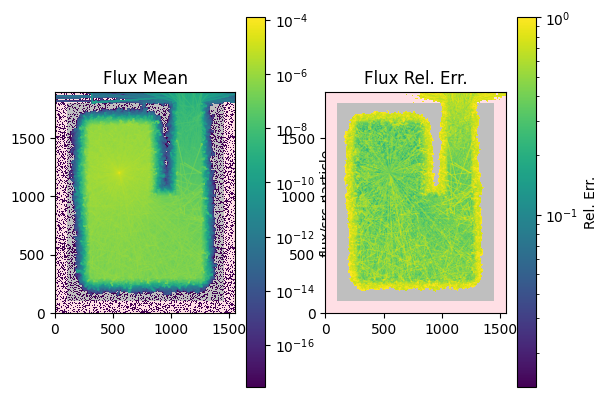

In [17]:
plot_mesh_tally(model, f'statepoint.{settings.batches}.h5')
plt.show()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ipython-input-12-63ec263adb15>:30: RuntimeWarning: invalid value encountered in divide
  flux_std_dev.T/flux_mean.T,


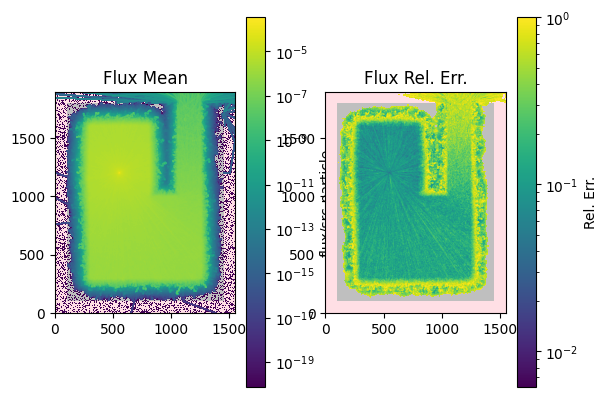

In [18]:
# reduce particles and apply weight windows from the previous run
model.settings.particles = 1000
model.settings.weight_windows_file = 'weight_windows.h5'
model.settings.weight_windows_on = True
sp_file = model.run()
plot_mesh_tally(model, sp_file)
plt.show()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ipython-input-11-63ec263adb15>:30: RuntimeWarning: invalid value encountered in divide
  flux_std_dev.T/flux_mean.T,


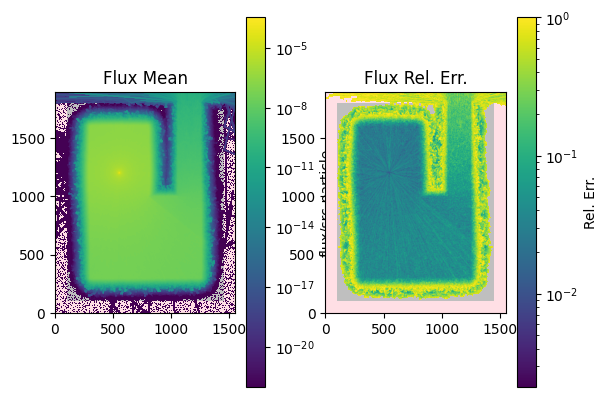

In [16]:
model.settings.particles = 10000
sp_file = model.run()
plot_mesh_tally(model, sp_file)
plt.show()

In [22]:
new_settings = openmc.Settings()
new_settings.weight_windows_on = True
new_settings.weight_window_checkpoints = {'collision': True, 'surface': True}
new_settings.particles = 1000
new_settings.batches = 50
new_settings.run_mode = 'fixed source'
new_settings.source = source
new_settings.statepoint = {'batches': list(range(5, new_settings.batches, 5))}

In [21]:
new_settings.statepoint

{'batches': [5, 10, 15, 20, 25, 30, 35, 40, 45]}

In [ ]:
wwg = openmc.WeightWindowGenerator(mesh, 
                                   [0, 5e6], 
                                   'neutron', 
                                   'magic', 
                                   max_realizations=25, 
                                   update_interval=1, 
                                   on_the_fly=True)
new_settings.weight_window_generators = [wwg]

model.settings = new_settings
sp_file = model.run()
plot_mesh_tally(model, sp_file)
plt.show()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
import openmc
import openmc.lib

def lower_density_wwg(model, tally, density_factor=1.0):
    pass
